In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import real_data_loader
import torch
import visualize_stylized_facts as vsf

## Set seeds for reconstruction of the results

In [2]:
# Set seeds.
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

#### Load Data

Filter out selected times and stocks

In [3]:
real_loader = real_data_loader.RealDataLoader(cache="../data/cache")
real_data = real_loader.get_timeseries(
    col_name="Adj Close", data_path="../data/raw_yahoo_data", update_all=False
)
stocks = ["MSFT", "AAPL", "IBM", "ADBE", "ORCL", "INTC", "AMD", "HPQ"]
# stocks = ['INTC']
real_data = real_data.loc["1987-01-01":, stocks]
print(np.sum(np.isnan(real_data), axis=0))
print(f"Shape: {real_data.shape}")
# real_data.plot()
# plt.show()

Cached data found at ../data/cache/time_series_Adj_Close.csv.
MSFT    0
AAPL    0
IBM     0
ADBE    0
ORCL    0
INTC    0
AMD     0
HPQ     0
dtype: int64
Shape: (9365, 8)


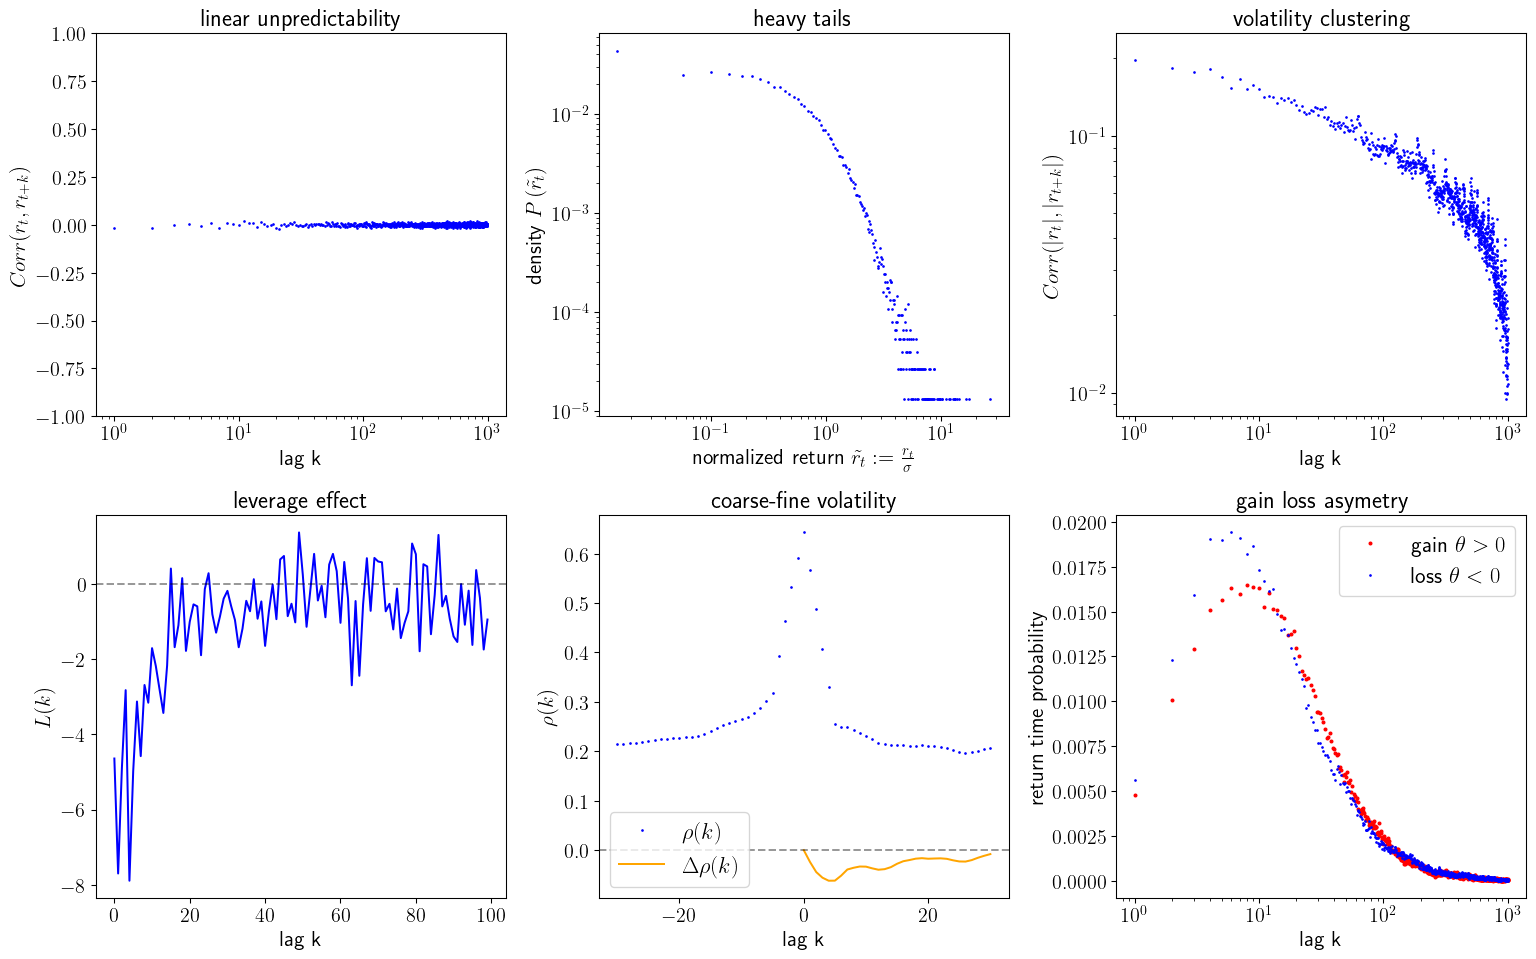

In [4]:
real_data_list = [real_data for _ in range(10)]
fig = vsf.visualize_averaged_stylized_facts(price_data_list=real_data_list)
plt.show()